<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/main/AnyNetTest-cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!nvcc --version
!pip3 show torch

Python 3.7.13
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Name: torch
Version: 1.10.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


In [ ]:
# Clone AnyNet
#!git clone https://github.com/mileyan/AnyNet.git
!git clone -b Colab_Test --single-branch https://github.com/Miragecore/AnyNet.git
%cd /content

In [ ]:
# 디버깅용 코드 블럭
%cd AnyNet
!git pull

In [ ]:
%%writefile setup.sh

### wget reference from => https://linux.tips/tutorials/download-large-google-drive-files-with-wget-in-terminal

### AnyNet Pretrained model : https://drive.google.com/file/d/18Vi68rQO-vcBn3882vkumIWtGggZQDoU/view?usp=sharing
### Anynet Pretrained Model File ID : 18Vi68rQO-vcBn3882vkumIWtGggZQDoU
wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=18Vi68rQO-vcBn3882vkumIWtGggZQDoU' -O 'checkpoint.zip'

#### KITTI Sceneflow https://drive.google.com/file/d/1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH/view?usp=sharing
### file ID : 1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH" -O KITTI_SceneFlow2015.zip && rm -rf /tmp/cookies.txt

if [ -d "checkpoint" ]; then
  ### Take action if $DIR exists ###
  echo "remove Last pretrained checkpoint.."
  rm -rf checkpoint
fi

echo "unzip pretrained model to checkpoint dir"
unzip checkpoint.zip

if [ -d "KITTI_SceneFlow2015" ]; then
  ### Take action if $DIR exists ###
  echo "remove Last KITTI_SceneFlow2015.."
  rm -rf KITTI_SceneFlow2015
fi

echo "unzip pretrained model to checkpoint dir"
unzip KITTI_SceneFlow2015.zip -d KITTI_SceneFlow2015

mkdir results

###build spn module
cd /content/AnyNet/models/spn_t1
./make.sh

Writing setup.sh


In [ ]:
%cd /content
!chmod +x ./setup.sh
!./setup.sh

In [ ]:
!python /content/AnyNet/finetune.py --maxdisp 192 --with_spn --datapath /content/KITTI_SceneFlow2015/training/ \
    --save_path /content/results/kitti2015 --datatype 2015 --pretrained /content/checkpoint/kitti2015_ck/checkpoint.tar \
    --split_file /content/checkpoint/kitti2015_ck/split.txt --evaluate

[2022-04-09 08:40:36 KITTIloader2015.py:33] INFO     [13, 32, 36, 37, 38, 43, 46, 54, 58, 62, 75, 76, 79, 82, 92, 93, 99, 106, 108, 114, 115, 117, 124, 131, 135, 138, 139, 141, 144, 148, 159, 162, 164, 167, 176, 179, 182, 192, 193, 199]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[2022-04-09 08:40:36 finetune.py:80] INFO     channels_3d: 4
[2022-04-09 08:40:36 finetune.py:80] INFO     datapath: /content/KITTI_SceneFlow2015/training/
[2022-04-09 08:40:36 finetune.py:80] INFO     datatype: 2015
[2022-04-09 08:40:36 finetune.py:80] INFO     epochs: 300
[2022-04-09 08:40:36 finetune.py

In [44]:
import AnyNet.models.anynet as models
from PIL import Image
import PIL
import torchvision.transforms as transforms
import numpy as np
import easydict
import torch.nn as nn
import torch.nn.parallel
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
import cv2

In [96]:
from os import kill
args = easydict.EasyDict({"init_channels": 1 , 
                          "maxdisplist": [12,3,3],  
                          "spn_init_channels" : 8,
                          "nblocks" : 2,
                          "layers_3d" : 4,
                          "channels_3d" : 4,
                          "growth_rate" : [4,1,1],
                          "with_spn" : False,
                          "pretrained" : "/content/checkpoint/kitti2015_ck/checkpoint.tar"})

#device = torch.device('cpu')
model = models.AnyNet(args).to(torch.device('cpu'))
#model.to(device)
#model = nn.DataParallel(model).cuda()
#checkpoint_cuda = torch.load(args.pretrained)
#print(checkpoint_cuda)
#checkpoint = torch.load(args.pretrained, map_location=device)
checkpoint = torch.load(args.pretrained, map_location=torch.device('cpu'))

from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k.replace("module.", "") # remove `module.`
    new_state_dict[name] = v
    #print(name)

print(checkpoint.keys())
#print(checkpoint['state_dict'])
model.load_state_dict(new_state_dict, strict=False)
#model.load_state_dict(checkpoint['state_dict'], strict=True)

dict_keys(['epoch', 'state_dict', 'optimizer'])


_IncompatibleKeys(missing_keys=[], unexpected_keys=['refine_spn.0.0.weight', 'refine_spn.0.2.weight', 'refine_spn.0.4.weight', 'refine_spn.0.6.weight', 'refine_spn.1.weight', 'refine_spn.2.weight'])

In [97]:
#1232, 368
def predict(left, right, crops=(0,0,1232,368)):
  left_img = Image.open(left).convert('RGB')
  right_img = Image.open(right).convert('RGB')
  #print("img shape : " + str(left_img.shape))
  left_img = left_img.crop(crops)
  right_img = right_img.crop(crops)
  #print("img shape af crop : " + str(left_img.shape))

  tf = transforms.ToTensor()

  left_img = tf(left_img).unsqueeze(0)
  right_img = tf(right_img).unsqueeze(0)
  print("shape af tf & unsqueeze: " + str(left_img.shape))

  return model(left_img, right_img)


def predict_cv2(left, right, crops=(0,0,1232, 368)):   # x_origin, y_origin, Width, Height
  left = cv2.imread(left)[crops[1]:crops[3], crops[0]:crops[2], :]
  right = cv2.imread(right)[crops[1]:crops[3], crops[0]:crops[2], :]
  print(left.shape)
  left_img = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
  right_img = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

  tf = transforms.ToTensor()

  left_img = tf(left_img).unsqueeze(0)
  right_img = tf(right_img).unsqueeze(0)

  return model(left_img, right_img)

def normalize8(I):
  mn = I.min()
  mx = I.max()

  mx -= mn

  I = ((I - mn)/mx) * 255
  return I.astype(np.uint8)


def show_tensor(tensor, fs=(16,12)):
    print("tensor len :" + str(len(tensor)))
    for i in range(len(tensor)):
      print('stage ' + str(i+1))
      img = tensor[i].detach().cpu().numpy() # tensor -> numpy
      print("bf squeeze : " + str(img.shape))
      img = img.squeeze()
      print("af squeeze : " + str(img.shape))
      print(img.dtype)
      img = normalize8(img).astype(np.uint8)
      #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
      cimg = cv2.applyColorMap(img, cv2.COLORMAP_JET)
      cv2_imshow(cimg)
      #fig = plt.figure(figsize=fs)
      #plt.imshow(img)
      #plt.show()

(368, 1232, 3)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor len :3
stage 1
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


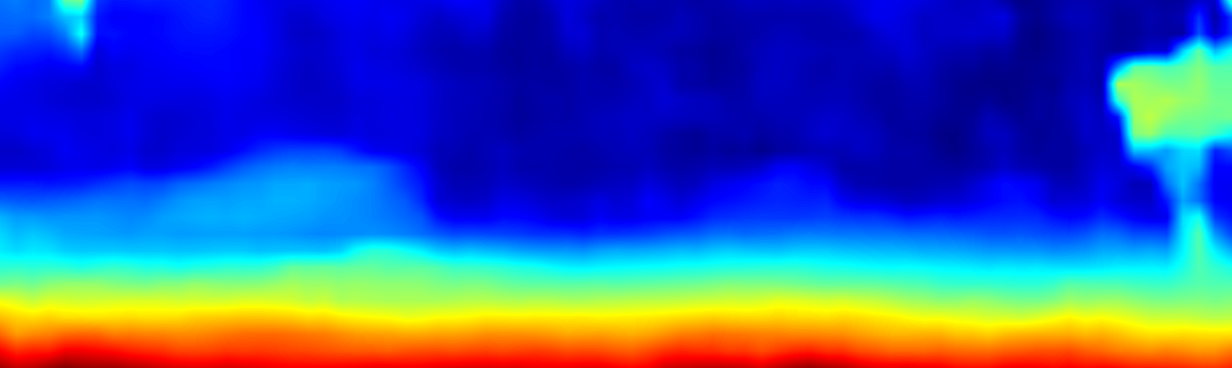

stage 2
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


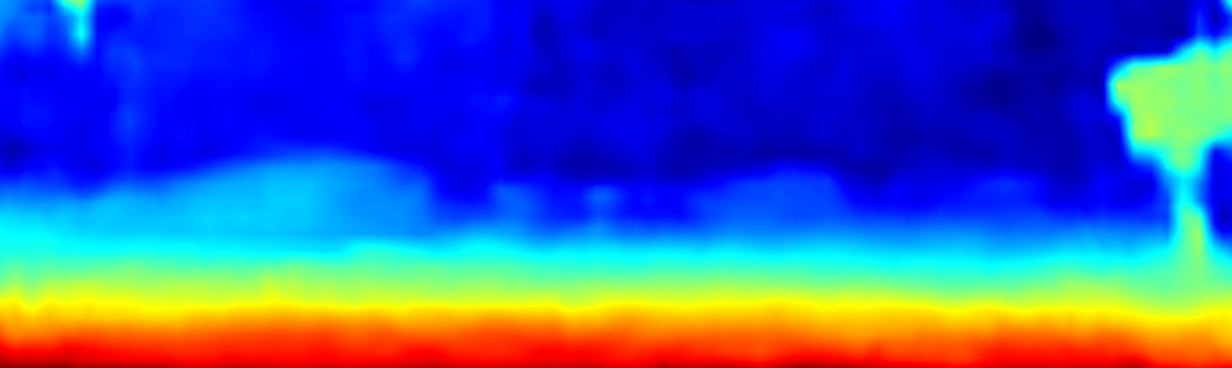

stage 3
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


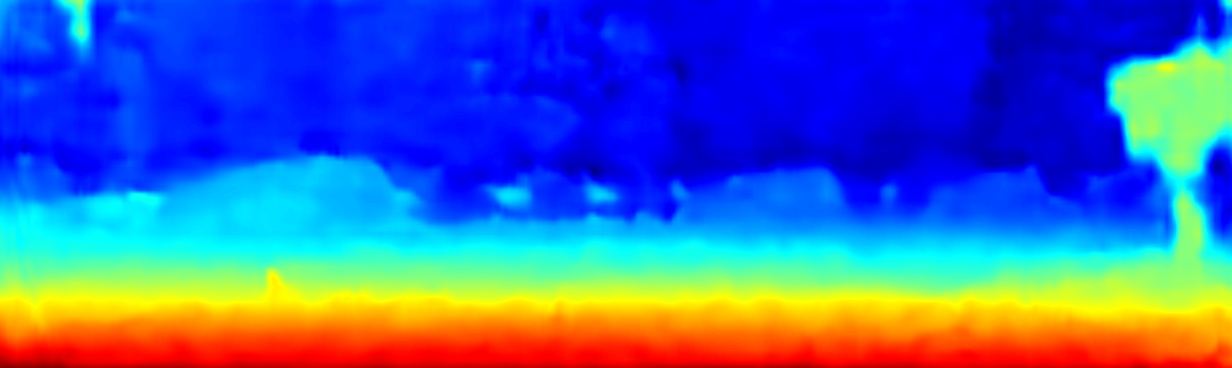

In [101]:
left = '/content/KITTI_SceneFlow2015/testing/image_2/000000_10.png'
right = '/content/KITTI_SceneFlow2015/testing/image_3/000000_10.png'
pr = predict_cv2(left, right)

show_tensor(pr)

shape af tf & unsqueeze: torch.Size([1, 3, 368, 1232])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor len :3
stage 1
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


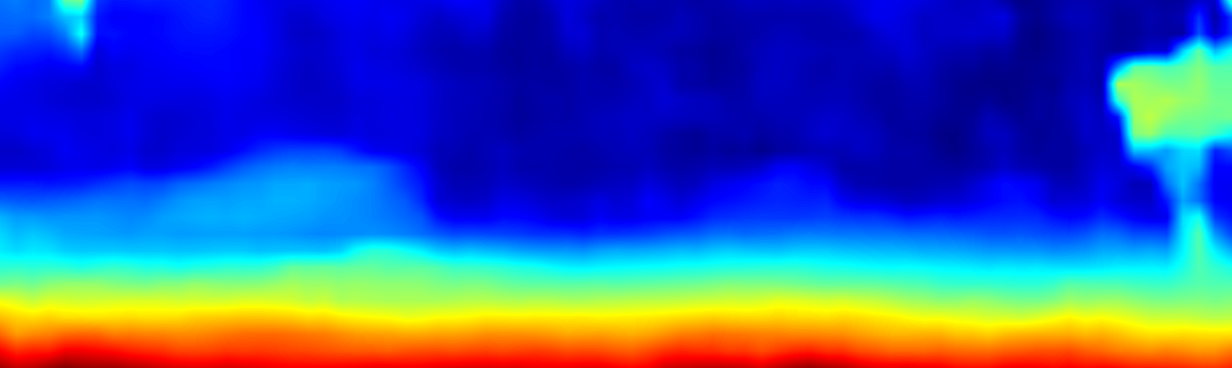

stage 2
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


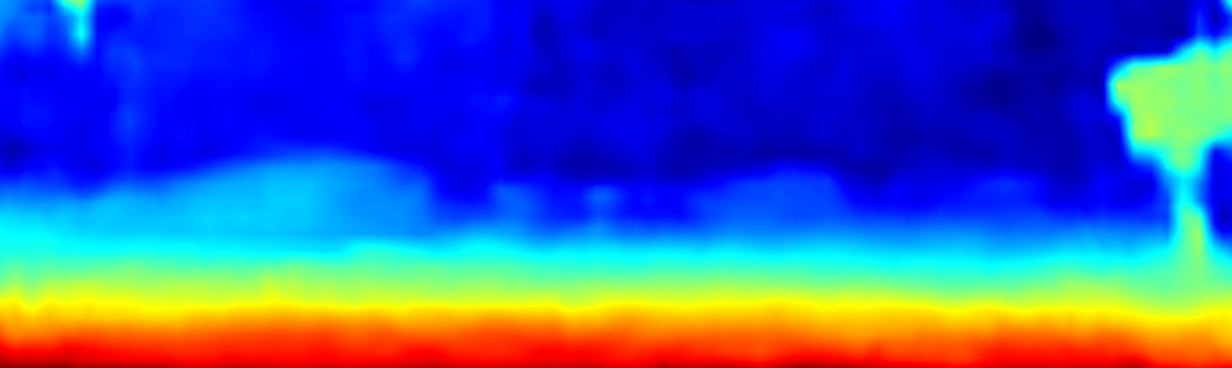

stage 3
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
float32


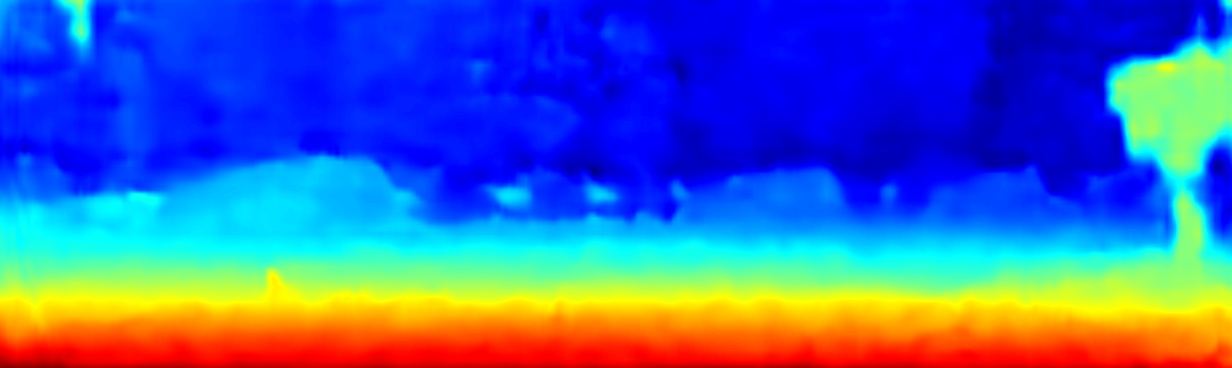

In [99]:
left = '/content/KITTI_SceneFlow2015/testing/image_2/000000_10.png'
right = '/content/KITTI_SceneFlow2015/testing/image_3/000000_10.png'
pr = predict(left, right)

show_tensor(pr)

In [92]:
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0001.jpg
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0002.jpg

--2022-04-12 17:05:10--  https://github.com/Miragecore/cando/raw/iss9/sample/frame0001.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Miragecore/cando/iss9/sample/frame0001.jpg [following]
--2022-04-12 17:05:10--  https://raw.githubusercontent.com/Miragecore/cando/iss9/sample/frame0001.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94992 (93K) [image/jpeg]
Saving to: ‘frame0001.jpg’

frame0001.jpg       100%[===================>]  92.77K  --.-KB/s    in 0.007s  

2022-04-12 17:05:10 (12.7 MB/s) - ‘frame0001.jpg’ saved [94992/94992]

--2022-04-12 17:05:11--  https://github.com/Mirag

(480, 640, 3)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor len :3
stage 1
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
float32


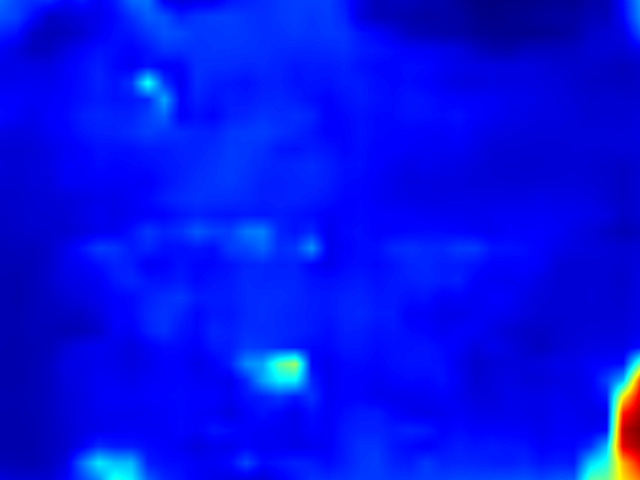

stage 2
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
float32


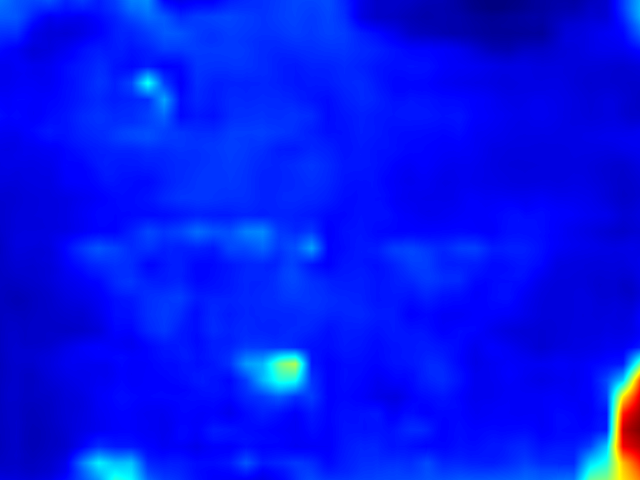

stage 3
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
float32


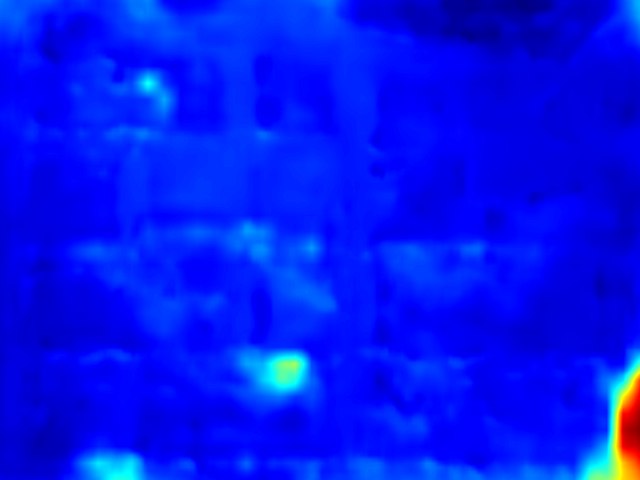

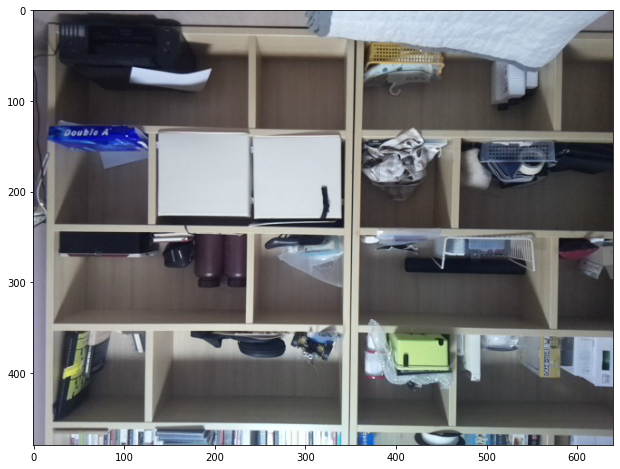

In [102]:
left = '/content/frame0002.jpg'
right = '/content/frame0001.jpg'

pr = predict_cv2(left, right, crops=(0,0,640,480))

fs = (12,8)
show_tensor(pr,fs)

import matplotlib.image as img
left_img = img.imread(left)
fig = plt.figure(figsize=fs)
plt.imshow(left_img)
plt.show()